# Milestone 3 - Pre-processing and analysis with PySpark.

# Tasks:

## Load the dataset.

In [1]:
from pyspark.sql import *
spark = SparkSession.builder.config("spark.jars", "postgresql-42.5.1.jar").appName("M3").getOrCreate()
sc = spark.sparkContext

In [2]:
from pyspark.sql.functions import *

In [3]:
df = spark.read.parquet('yellow_tripdata_2016-11.parquet')

### Preview first 20 rows.

In [4]:
df.show(vertical=True)

-RECORD 0-------------------------------------
 Vendor                | Creative Mobile T... 
 tpep_pickup_datetime  | 2016-11-01 01:02:29  
 tpep_dropoff_datetime | 2016-11-01 01:08:06  
 passenger_count       | 1.0                  
 trip_distance         | 1.4                  
 Rate_type             | Standard rate        
 store_and_fwd_flag    | N                    
 PU_Location           | Manhattan,Clinton... 
 DO_Location           | Manhattan,Lincoln... 
 payment_type          | Credit card          
 fare_amount           | 6.5                  
 extra                 | 0.5                  
 mta_tax               | 0.5                  
 tip_amount            | 1.55                 
 tolls_amount          | 0.0                  
 improvement_surcharge | 0.3                  
 total_amount          | 9.35                 
 congestion_surcharge  | null                 
 airport_fee           | null                 
-RECORD 1-------------------------------------
 Vendor      

### How many partitions is this dataframe split into?

In [5]:
num_partitions = df.rdd.getNumPartitions()

In [6]:
print(f"The DataFrame has {num_partitions} partitions.")

The DataFrame has 16 partitions.


## Basic cleaning

### rename all columns (replacing a space with an underscore, and making it lowercase)

In [7]:
current_columns = df.columns
print("Current Columns:", current_columns)

Current Columns: ['Vendor', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'Rate_type', 'store_and_fwd_flag', 'PU_Location', 'DO_Location', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


In [8]:
new_columns = [col.replace(' ', '_').lower() for col in current_columns]
df_renamed = df.toDF(*new_columns)

In [9]:
columns_renamed = df_renamed.columns
print(columns_renamed)

['vendor', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'rate_type', 'store_and_fwd_flag', 'pu_location', 'do_location', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


### Detect and remove duplicates
- Duplicates are trips with same pickup time,pickup location, dropoff time,drop off location and trip distance

In [10]:
duplicate_columns = ["tpep_pickup_datetime", "pu_location", "tpep_dropoff_datetime", "do_location", "trip_distance"]

In [11]:
df_renamed.count()

10102133

In [12]:
duplicates_count = df_renamed.count() - df_renamed.dropDuplicates(duplicate_columns).count()
print("Number of duplicates = ", duplicates_count)

Number of duplicates =  4694


In [13]:
df_dup_removed =  df_renamed.dropDuplicates(duplicate_columns)

### check that there is are no duplicates

- Since the df_dup_removed has less number of columns therefor is does not have duplicates 

In [14]:
df_dup_removed.count()

10097439

- Trying to remove duplicates but there are no duplicates

In [15]:
num_after_removing = df_dup_removed.count() - df_dup_removed.dropDuplicates(duplicate_columns).count()
print("number of duplicates after removing = ", num_after_removing)

number of duplicates after removing =  0


### Detect missing
- Create a function that takes in the df and returns any data structrue of your choice(df/dict,list,tuple,etc) which has the name of the column and percentage of missing entries from the whole dataset.
- Tip : storing the missing info as dict where the key is the column name and value is the percentage would be the easiest.  

In [16]:
def missing_percentage(df):
    total_rows = df.count()

    # Calculate the percentage of missing values for each column
    missing_info = []
    for col_name in df.columns:
        missing_count = df.filter(col(col_name).isNull() | (col(col_name) == "")).count()
        percentage_missing = (missing_count / total_rows) * 100
        missing_info.append(Row(column=col_name, percentage_missing=percentage_missing))

    # Create a DataFrame from the missing information
    features = ["column", "percentage_missing"]
    missing_df = spark.createDataFrame(missing_info, schema=features)

    return missing_df


In [17]:
missing_info_df = missing_percentage(df_dup_removed)

### Prinout the missing info

In [18]:
missing_info_df.show()

+--------------------+--------------------+
|              column|  percentage_missing|
+--------------------+--------------------+
|              vendor|                 0.0|
|tpep_pickup_datetime|                 0.0|
|tpep_dropoff_date...|                 0.0|
|     passenger_count|0.004892329629324821|
|       trip_distance|                 0.0|
|           rate_type|                 0.0|
|  store_and_fwd_flag|                 0.0|
|         pu_location|                 0.0|
|         do_location|                 0.0|
|        payment_type|    8.84656990747852|
|         fare_amount|                 0.0|
|               extra|   53.66090352217032|
|             mta_tax|                 0.0|
|          tip_amount|                 0.0|
|        tolls_amount|                 0.0|
|improvement_surch...|                 0.0|
|        total_amount|                 0.0|
|congestion_surcharge|               100.0|
|         airport_fee|               100.0|
+--------------------+----------

### Handle missing
- For numerical features replace with 0.
- For categorical/strings replace with 'Unknown'


In [19]:
# Drop congestion_surcharge and airport_fee because they have 100% nulls
columns_to_drop = ["congestion_surcharge", "airport_fee"]  # Replace with the actual column names
df_after_drop_allnull = df_dup_removed.drop(*columns_to_drop)

In [20]:
df_after_drop_allnull.columns

['vendor',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'rate_type',
 'store_and_fwd_flag',
 'pu_location',
 'do_location',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [21]:
numerical_columns = ["passenger_count", "extra"]  
df_imputed = df_after_drop_allnull.fillna(0, subset=numerical_columns)

In [22]:
categorical_columns = ["payment_type"]  
df_imputed = df_imputed.fillna('Unknown', subset=categorical_columns)

### check that there are no missing values

In [23]:
missing_imputed_df = missing_percentage(df_imputed)

In [24]:
missing_imputed_df.show()

+--------------------+------------------+
|              column|percentage_missing|
+--------------------+------------------+
|              vendor|               0.0|
|tpep_pickup_datetime|               0.0|
|tpep_dropoff_date...|               0.0|
|     passenger_count|               0.0|
|       trip_distance|               0.0|
|           rate_type|               0.0|
|  store_and_fwd_flag|               0.0|
|         pu_location|               0.0|
|         do_location|               0.0|
|        payment_type|               0.0|
|         fare_amount|               0.0|
|               extra|               0.0|
|             mta_tax|               0.0|
|          tip_amount|               0.0|
|        tolls_amount|               0.0|
|improvement_surch...|               0.0|
|        total_amount|               0.0|
+--------------------+------------------+



## Feature engineering - 
Write a function that adds the 3 following features. Use built in fucntions in PySpark (from the functions library) check lab 8, Avoid writing UDFs from scratch.
- trip duration (the format/unit is up to you)
- is_weekend. whether the trip occurred on Saturday or Sunday.
- week number (relevant to the month and not year, i.e 1,2,3,4 nto 31,32,33...) 

In [25]:
def add_features(df):
    # 1. Trip Duration (in seconds)
    df = df.withColumn("trip_duration_minutes", ((unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")))/60 )

    # 2. Is Weekend (1 if weekend, 0 otherwise)
    df = df.withColumn("is_weekend", expr("CASE WHEN DAYOFWEEK(tpep_pickup_datetime) IN (1, 7) THEN 1 ELSE 0 END"))

    # 3. Week Number (using EXTRACT)
    df = df.withColumn("week_number", expr("EXTRACT(WEEK FROM tpep_pickup_datetime)"))

    return df

In [26]:
# Call the function with your DataFrame
df_with_features = add_features(df_imputed)

### Preview the first 20 rows (only select the following features: pickup and droptime, and the 3 features you added). 

In [27]:
selected_features_df = df_with_features.select("tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_duration_minutes", "is_weekend", "week_number")

In [28]:
selected_features_df.show()

+--------------------+---------------------+---------------------+----------+-----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_duration_minutes|is_weekend|week_number|
+--------------------+---------------------+---------------------+----------+-----------+
| 2016-11-01 01:03:23|  2016-11-01 01:10:38|                 7.25|         0|         44|
| 2016-11-01 01:05:38|  2016-11-01 01:13:26|                  7.8|         0|         44|
| 2016-11-01 01:09:26|  2016-11-01 01:17:21|    7.916666666666667|         0|         44|
| 2016-11-01 01:14:52|  2016-11-01 01:18:58|                  4.1|         0|         44|
| 2016-11-01 01:03:01|  2016-11-01 01:19:08|   16.116666666666667|         0|         44|
| 2016-11-01 01:00:47|  2016-11-01 01:19:41|                 18.9|         0|         44|
| 2016-11-01 01:13:09|  2016-11-01 01:20:14|    7.083333333333333|         0|         44|
| 2016-11-01 01:08:20|  2016-11-01 01:20:52|   12.533333333333333|         0|         44|
| 2016-11-

## Analyses - Answer the following 5 questions (by showing the output and and a short 1-2 sentences regarding your observation/answer) 

MUST Use the PySpark SQL API.

DO NOT explicitly write SQL queries. Doing so will result in 50% deduction (for the question). Check lab 7.

You are free to add columns if it will help in answering a question and add useful info to the dataset.

### 1- What is the average fare amount per payment type 

In [29]:
mean_fare_per_payment_type = (df_with_features.groupBy("payment_type").agg(mean("fare_amount").alias("av_fare_per_type")))

mean_fare_per_payment_type.show()

+------------+------------------+
|payment_type|  av_fare_per_type|
+------------+------------------+
|     Unknown|13.123331340670354|
|        Cash|12.410713221152061|
|     Dispute|28.196506354348383|
|   No charge|11.562185502165407|
| Credit card|13.854085105350435|
+------------+------------------+



- There is no exact reason about this results but maybe dispute have higher fare amount  which could be a result of billing errors, where the charged amount is inaccurately recorded or communicated. Disputes may arise if the customer believes they were overcharged.

### 2- Do people tend to go on a longer trips during the weekend or weekdays?

In [30]:
mean_distance = (df_with_features.groupBy("is_weekend").agg( mean("trip_distance").alias("av_fare_per_type") ))
mean_distance.show()

+----------+-----------------+
|is_weekend| av_fare_per_type|
+----------+-----------------+
|         1|3.122610839675927|
|         0| 2.93177910635172|
+----------+-----------------+



- It is observed that people have longer trips on weekends since they may be traveling somewhere for a trip or they may visit there families that are living in another city or another place far from them which make sense for me 

### 3 - which day recorded the most trips?

In [38]:
# Convert the timestamp to the day of the week
df_with_day_of_week = df_with_features.withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))
# Group by the day of the week and count the number of trips
trips_by_day_of_week = df_with_day_of_week.groupBy("day_of_week").agg(count("*").alias("trip_count"))
trips_by_day_of_week.show()

+-----------+----------+
|day_of_week|trip_count|
+-----------+----------+
|          1|   1344016|
|          6|   1346804|
|          3|   1667116|
|          5|   1318131|
|          4|   1709279|
|          7|   1452027|
|          2|   1260066|
+-----------+----------+



In [39]:
# Find the date with the maximum trips
most_trips_date = (trips_by_day_of_week.orderBy(col("trip_count").desc()).select("day_of_week").first())
print(f"The day with the most trips is day {most_trips_date['day_of_week']}")

The day with the most trips is day 4


**NO COMMENT**

### 4- What is the average "total amount" of trips with more than 2 passengers?

In [40]:
more_than_two_df = df_with_features.select("total_amount").where("passenger_count > 2")
more_than_two_df.show()

+------------+
|total_amount|
+------------+
|         6.3|
|        27.3|
|        13.5|
|        23.8|
|       17.16|
|       20.16|
|       18.96|
|        17.8|
|       14.76|
|        23.8|
|         5.8|
|        8.16|
|        11.0|
|         7.3|
|       11.15|
|        13.8|
|         7.3|
|        9.36|
|         4.3|
|       41.34|
+------------+
only showing top 20 rows



In [41]:
mean_total_amount = more_than_two_df.agg(mean("total_amount").alias("mean_total_amount"))

mean_total_amount.show()

+------------------+
| mean_total_amount|
+------------------+
|16.746363663126903|
+------------------+



**NO COMMENT**

### 5- On average, when is it more likely that the tip is higher, when there are multiple passengers or just 1.?

In [42]:
#DataFrame with passenger count = 1
passenger_count_1_df = df_with_features.filter(col("passenger_count") == 1).withColumn("passenger_counts", lit("1"))

#DataFrame with passenger count > 1
passenger_count_gt_1_df = df_with_features.filter(col("passenger_count") > 1).withColumn("passenger_counts", lit("more than 1"))

# Union the two DataFrames
combined_df = passenger_count_1_df.union(passenger_count_gt_1_df)

In [43]:
# Calculate the average tip amount for each passenger type
average_tip_by_passenger_type = combined_df.groupBy("passenger_counts").agg(avg("tip_amount").alias("avg_tip_amount"))
# Show the result
average_tip_by_passenger_type.show()

+----------------+------------------+
|passenger_counts|    avg_tip_amount|
+----------------+------------------+
|     more than 1| 1.808651251144986|
|               1|1.8515097994741052|
+----------------+------------------+



**NO COMMENT**

### 6- What is the most frequent route on the weekend. 

In [44]:
# Create a new column representing the route as a combination of pickup and destination locations
df_with_route = df_with_features.withColumn("route", concat(col("pu_location"), lit(" to "), col("do_location")))

# Filter the DataFrame for routes on the weekend
routes_on_weekend_df = df_with_route.filter(col("is_weekend") == 1)


In [45]:
# Group by the route and calculate the count for each route
route_counts_df = routes_on_weekend_df.groupBy("route").count()

# Find the most frequent route
most_frequent_route_df = route_counts_df.orderBy(col("count").desc()).limit(1)

In [46]:
most_frequent_route_df.show()

+--------------------+-----+
|               route|count|
+--------------------+-----+
|Unknown,NV to Unk...|35559|
+--------------------+-----+



**NO COMMENT** 

## Encoding
- Label encode all categorical fetaures.
- Create a lookup table for these label encoded features. You can use the same format/example as the lookup table in Milestone 1 description.

(You are allowed to store and manipulate the lookup table as a pandas dataframe, it does not have to be a PySpark df).
- Remove the original unencoded categorical features from the df after encoding.

In [47]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [48]:
# Define the list of categorical features to label encode
categorical_features = ["rate_type", "store_and_fwd_flag", "pu_location", "do_location", "payment_type"]

# Initialize a StringIndexer for each categorical feature
indexers = [StringIndexer(inputCol=feature, outputCol=f"{feature}_indexed", handleInvalid="keep") for feature in categorical_features]

# Create a pipeline with all StringIndexers
pipeline = Pipeline(stages=indexers)

# Fit the pipeline on the data
model = pipeline.fit(df_with_features)

# Transform the data
df_encoded = model.transform(df_with_features)

In [49]:
#Drop the original unencoded categorical features
df_cleaned = df_encoded.drop(*categorical_features)

### Preview first 20 rows of the label encoded features

In [50]:
df_cleaned.show(vertical = True)

-RECORD 0------------------------------------------
 vendor                     | Creative Mobile T... 
 tpep_pickup_datetime       | 2016-11-01 01:03:23  
 tpep_dropoff_datetime      | 2016-11-01 01:10:38  
 passenger_count            | 1.0                  
 trip_distance              | 1.6                  
 fare_amount                | 8.0                  
 extra                      | 0.5                  
 mta_tax                    | 0.5                  
 tip_amount                 | 1.7                  
 tolls_amount               | 0.0                  
 improvement_surcharge      | 0.3                  
 total_amount               | 11.0                 
 trip_duration_minutes      | 7.25                 
 is_weekend                 | 0                    
 week_number                | 44                   
 rate_type_indexed          | 0.0                  
 store_and_fwd_flag_indexed | 0.0                  
 pu_location_indexed        | 11.0                 
 do_location

### Preview first 20 rows of your lookup table

In [51]:
lookup_table = df_encoded.select(['rate_type', 'rate_type_indexed',
                                 'store_and_fwd_flag', 'store_and_fwd_flag_indexed',
                                 'pu_location', 'pu_location_indexed', 
                                  'do_location', 'do_location_indexed',
                                   'payment_type', 'payment_type_indexed',
                                         ]).distinct().toPandas()

In [52]:
lookup_table.head(20)

,rate_type,rate_type_indexed,store_and_fwd_flag,store_and_fwd_flag_indexed,pu_location,pu_location_indexed,do_location,do_location_indexed,payment_type,payment_type_indexed
0,Standard rate,0.0,N,0.0,"Manhattan,Little Italy/NoLiTa",37.0,"Manhattan,Greenwich Village North",26.0,Credit card,0.0
1,Standard rate,0.0,N,0.0,"Manhattan,Murray Hill",9.0,"Manhattan,Upper East Side North",0.0,Credit card,0.0
2,Standard rate,0.0,N,0.0,"Manhattan,Murray Hill",9.0,"Manhattan,Midtown East",4.0,Unknown,2.0
3,Standard rate,0.0,N,0.0,"Manhattan,Sutton Place/Turtle Bay North",22.0,"Manhattan,UN/Turtle Bay South",27.0,Credit card,0.0
4,Standard rate,0.0,N,0.0,"Manhattan,Greenwich Village North",27.0,"Manhattan,Upper East Side South",1.0,Cash,1.0
5,Standard rate,0.0,N,0.0,"Manhattan,Times Sq/Theatre District",5.0,"Manhattan,Clinton East",8.0,Credit card,0.0
6,Standard rate,0.0,N,0.0,"Manhattan,Battery Park City",40.0,"Manhattan,TriBeCa/Civic Center",20.0,Unknown,2.0
7,Standard rate,0.0,N,0.0,"Brooklyn,Columbia Street",113.0,"Manhattan,Sutton Place/Turtle Bay North",22.0,Credit card,0.0
8,Standard rate,0.0,N,0.0,"Manhattan,Midtown South",16.0,"Manhattan,Greenwich Village South",35.0,Credit card,0.0
9,Standard rate,0.0,N,0.0,"Manhattan,Midtown Center",3.0,"Manhattan,Battery Park City",39.0,Unknown,2.0


### Load the cleaned PySpark df to a parquet file and the lookup table to a csv file.

In [53]:
# Save the cleaned PySpark DataFrame to a Parquet file
df_cleaned.write.parquet("yellow_tripdata_2016-11clean.parquet", mode="overwrite")

# Save the lookup table to a CSV file
lookup_table.to_csv("lookup_table_yello_taxi.csv", index=False)

## Bonus - Load the cleaned parquet file and lookup table into a Postgres database. 

Note that if you decide to do the bonus, you must include not only your notebook but the docker-compose.yaml file aswell.

In [54]:
# Load the cleaned data from the Parquet file
cleaned_data = spark.read.parquet("yellow_tripdata_2016-11clean.parquet")

cleaned_data.write.jdbc(
    url="jdbc:postgresql://pgdatabase:5432/yellow_taxi_db",
    table="clean_data",
    mode="overwrite",
    properties={
        "user": "root",
        "password": "root",
        "driver": "org.postgresql.Driver"
    }
)


In [55]:
# Load the lookup table from the CSV file
lookup_table = spark.read.csv("lookup_table_yello_taxi.csv", header=True, inferSchema=True)

# Write the lookup table to PostgreSQL
lookup_table.write.jdbc(url="jdbc:postgresql://pgdatabase:5432/yellow_taxi_db", table="lookup_table", mode="overwrite", properties={"user": "root", "password": "root", "driver": "org.postgresql.Driver"})

### Screenshot of the table existing in the database and a simple query such as `select count(*) from table_name` or `select * from table_name limit 10`

(You can just copy paste the screenshots in the markdown cells below)

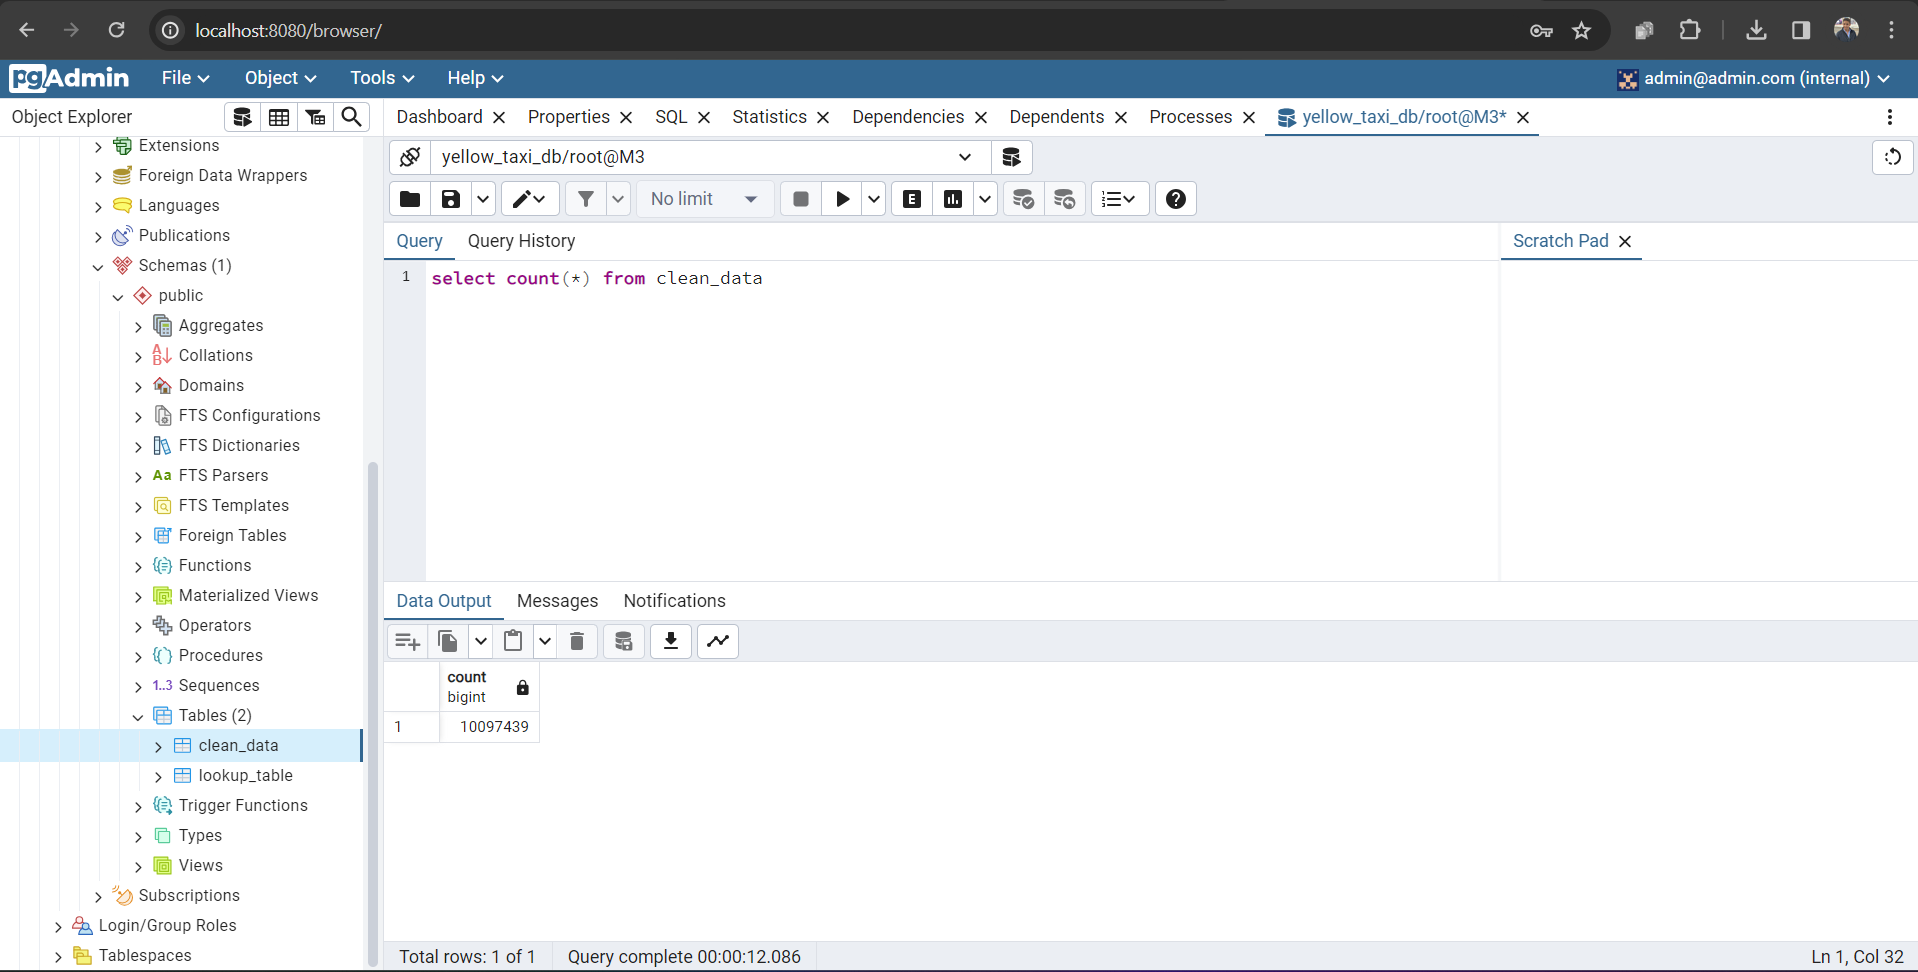

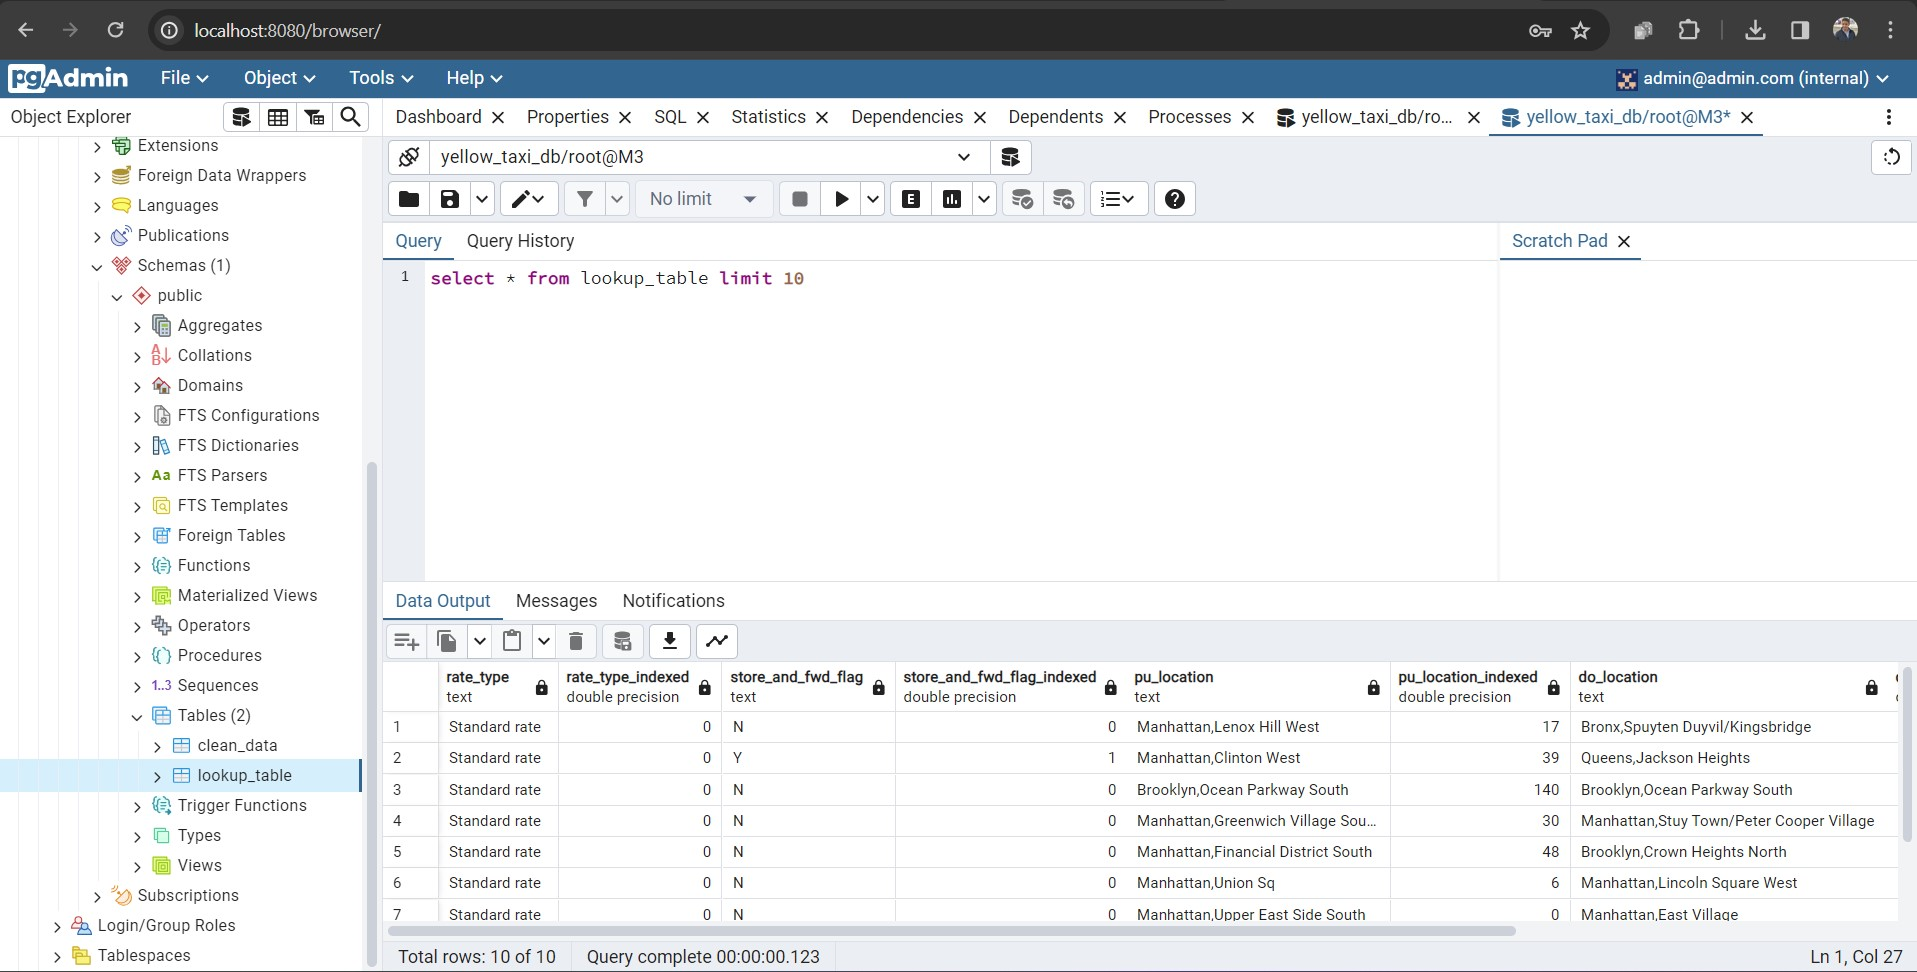